In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np 
from scipy.stats import kstest, false_discovery_control
import scipy
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

plt.rcParams.update({'font.size': 24})


## import data

In [3]:
data = pd.read_csv('../data/allClinvarMissense.csv',header=0,index_col=0)

## cleanup

In [4]:
data['class']='none'
data['disease_associated']='NO'
data.loc[~data['disease'].str.contains('not'),'disease_associated']='YES'
data['more_pos']='NO'
data['more_neg']='NO'
data.loc[data['changeType'].str.contains('neg>|>pos'),'more_pos']='YES'
data.loc[data['changeType'].str.contains('>neg|pos>'),'more_neg']='YES'
data['significance']=data['signi']
data.loc[data['signi'].str.contains('Benign|benign'),'significance']='Likely_benign'
data.loc[data['signi'].str.contains('Conflicting'),'significance']='Unknown_significance'
data.loc[data['signi'].str.contains(r'uncertain',case=False),'significance']='Unknown_significance'
data.loc[data['signi'].str.contains(r'pathogenic|risk',case=False),'significance']='Likely_pathogenic'
data.loc[data['signi'].str.contains(r'other|protective|drug|not_provided|Affects|sensitivity|unflagged|association',case=False),'significance']='Not_provided'
data['resDisordered']='ND'
data.loc[data['res_disorder']>0.7,'resDisordered']='YES'
data.loc[data['res_disorder']<0.3,'resDisordered']='NO'

In [25]:
pval_cols = data.columns[data.columns.str.contains('pval')]
data[pval_cols]=data[pval_cols].fillna(1)
for i in pval_cols:
    data[i+'_adj'] = -np.log10(scipy.stats.false_discovery_control(np.power(10,-data[i])))

## counts

In [27]:
N_all_prots = data[['upID','N_res','N_disordered']].drop_duplicates().shape[0]
N_all = data.shape[0]
N_all_diseaseAssociated = data[data['disease_associated']=='YES'].shape[0]
N_all_unknownSig = data[data['significance']=='Unknown_significance'].shape[0]
N_IDR = data[data['resDisordered']=='YES'].shape[0]
N_IDR_diseaseAssociated = data[(data['resDisordered']=='YES')&(data['disease_associated']=='YES')].shape[0]
N_IDR_unknownSig = data[(data['resDisordered']=='YES')&(data['significance']=='Unknown_significance')].shape[0]
N_expand = data[(data['resDisordered']=='YES')&(data['mut_vs_wt_Re_logFC_30']>0)&(data['mut_vs_wt_Re_pval_30_adj']>1.3)].shape[0]
N_compact = data[(data['resDisordered']=='YES')&(data['mut_vs_wt_Re_logFC_30']<0)&(data['mut_vs_wt_Re_pval_30_adj']>1.3)].shape[0]
N_nochange = data[(data['resDisordered']=='YES')&(data['mut_vs_wt_Re_pval_30_adj']<1.3)].shape[0]
N_Re_change = data[(data['resDisordered']=='YES')&(data['mut_vs_wt_Re_pval_30_adj']>1.3)].shape[0]
N_Re_change_prots = data[(data['resDisordered']=='YES')&(data['mut_vs_wt_Re_pval_30_adj']>1.3)]['upID'].unique().shape[0]
print('total proteins in dataset: %i' % N_all_prots)
print('total variants in IDRs / all / ratio: %i / %i / %.2f' % (N_IDR,N_all,N_IDR/N_all))
print('ratio of disease associated variants in IDRs / all: %.2f / %.2f'%
      (N_IDR_diseaseAssociated/N_IDR,N_all_diseaseAssociated/N_all))
print('ratio of VUSs in IDRs / all: %.3f / %.3f' % 
      (N_IDR_unknownSig/N_IDR,N_all_unknownSig/N_all))
print('total variants that expand/compact/do nothing in IDRs: %i / %i / %i' % 
      (N_expand,N_compact,N_nochange))
print('total number of variants that change ensemble: %i in %i proteins'%(N_Re_change,N_Re_change_prots))

total proteins in dataset: 19981
total variants in IDRs / all / ratio: 277103 / 971579 / 0.29
ratio of disease associated variants in IDRs / all: 0.26 / 0.30
ratio of VUSs in IDRs / all: 0.842 / 0.848
total variants that expand/compact/do nothing in IDRs: 8165 / 20691 / 248247
total number of variants that change ensemble: 28856 in 7270 proteins


## histograms of variant Re of different lengths

Text(0.5, 0, '$\\langle R_e \\rangle \\ (\\AA)$')

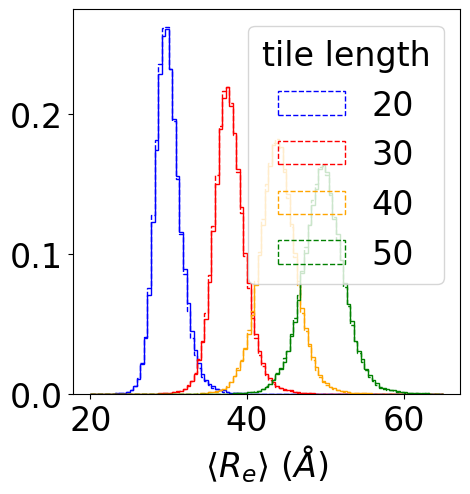

In [28]:
fig,ax = plt.subplots(figsize=[5,5])
bins = np.linspace(20,65,100)
colors=['blue','red','orange','green']
for i,window in enumerate(['20','30','40','50']):
    _=ax.hist(data.loc[(data['resDisordered']=='YES'),'mut_Re_avg_'+window],linestyle='--',density=True,bins=bins,histtype='step',color=colors[i],label=window)
    _=ax.hist(data.loc[(data['resDisordered']=='YES'),'wt_Re_avg_'+window],density=True,bins=bins,histtype='step',color=colors[i])
ax.legend(title='tile length')
ax.set_xlabel(r'$\langle R_e \rangle \ (\AA)$')

## Re Volcano plots for different tile lengths

20-res tiles: no change: 230539 (0.91), compacting: 16107 (0.06), expanding: 6108 (0.02)
30-res tiles: no change: 223734 (0.89), compacting: 20681 (0.08), expanding: 8153 (0.03)
40-res tiles: no change: 270655 (1.00), compacting: 7 (0.00), expanding: 0 (0.00)
50-res tiles: no change: 265797 (1.00), compacting: 344 (0.00), expanding: 53 (0.00)


(-5.0, 5.0)

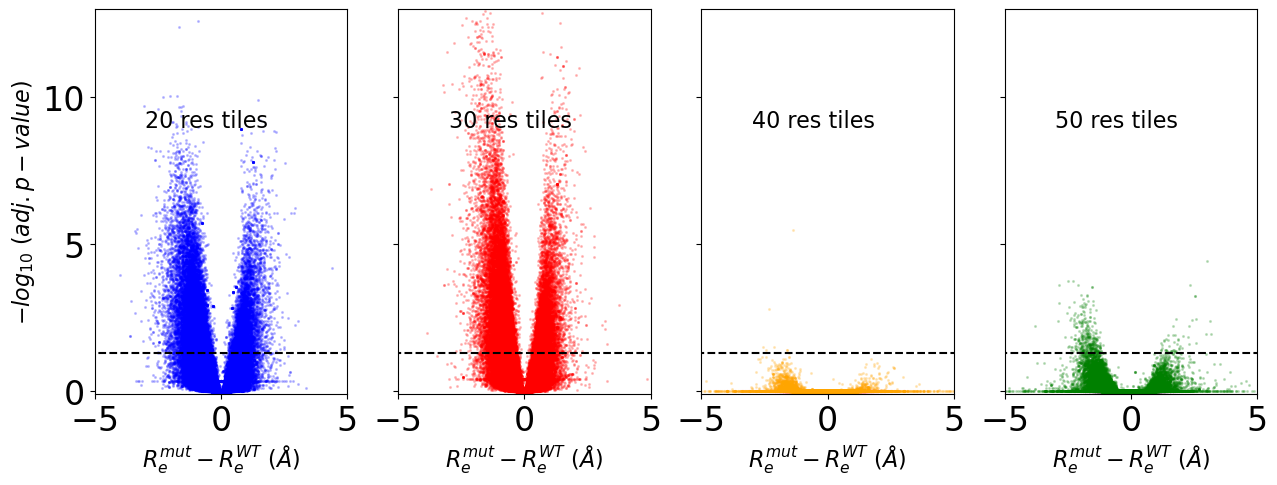

In [30]:
fig,ax=plt.subplots(1,4,figsize=[15,5],sharex=True,sharey=True)
window='30'
p_val_max=-np.log10(0.05)
delta_min = 0
colors=['blue','red','orange','green']

for i,window in enumerate(['20','30','40','50']):
    sliced=data[(data['resDisordered']=='YES')]
    N_expand = sliced[(sliced['mut_vs_wt_Re_delta_'+window]>0)&(sliced['mut_vs_wt_Re_pval_'+window+'_adj']>p_val_max)].shape[0]
    N_compact = sliced[(sliced['mut_vs_wt_Re_delta_'+window]<0)&(sliced['mut_vs_wt_Re_pval_'+window+'_adj']>p_val_max)].shape[0]
    N_nochange = sliced[(sliced['mut_vs_wt_Re_pval_'+window]<p_val_max)].shape[0]
    N_tot = N_expand+N_compact+N_nochange
    print('%s-res tiles: no change: %i (%.2f), compacting: %i (%.2f), expanding: %i (%.2f)'%
          (window, N_nochange,N_nochange/N_tot,N_compact,N_compact/N_tot,N_expand,N_expand/N_tot))
   # ax_inset = ax[i].inset_axes([0.6, 0.6, 0.3, 0.3])
   # ax_inset.pie([N_expand,N_compact], colors=['blue','red'])
    ax[i].scatter(sliced['mut_vs_wt_Re_delta_'+window],sliced['mut_vs_wt_Re_pval_'+window+'_adj'],
                s=1.5,alpha=0.2,color=colors[i])
    ax[i].plot([-10,10],[1.3,1.3],'--',c='k')
    ax[i].text(-3,9,window+' res tiles',fontsize=16)
    ax[i].set_xlabel(r'$R_{e}^{mut}-R_{e}^{WT}\ (\AA)$',fontsize=16)
ax[0].set_ylabel(r'$-log_{10}\ (adj. p-value)$',fontsize=16)
ax[0].set_ylim(-0.1,13)
ax[0].set_xlim(-5,5)

## Volcano for Fig. 2

C:\Users\ssukenik\AppData\Local\Temp\ipykernel_60848\3988759976.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sliced['color']='grey'


total: 277103, no change: 248269 (0.896), compacting: 20681 (0.075), expanding: 8153 (0.029)
15095


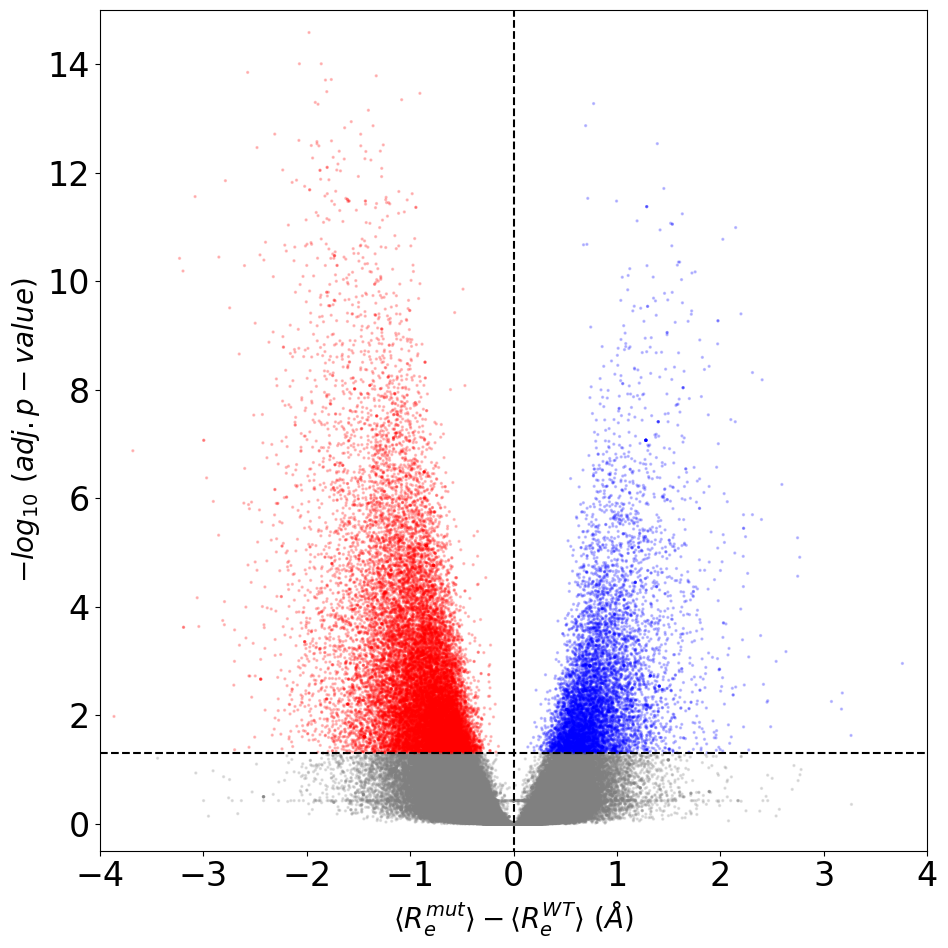

In [35]:
fig,ax=plt.subplots(figsize=[10,10])
window='30'
p_val_max=-np.log10(0.05)
delta_min = 0

sliced=data[(data['resDisordered']=='YES')]
sliced['color']='grey'
sliced.loc[(sliced['mut_vs_wt_Re_delta_'+window]>delta_min)&(sliced['mut_vs_wt_Re_pval_'+window+'_adj']>p_val_max),'color']='b'
sliced.loc[(sliced['mut_vs_wt_Re_delta_'+window]<-delta_min)&(sliced['mut_vs_wt_Re_pval_'+window+'_adj']>p_val_max),'color']='r'
ax.scatter(sliced['mut_vs_wt_Re_delta_'+window],sliced['mut_vs_wt_Re_pval_'+window+'_adj'],
                s=2,alpha=0.2,color=sliced['color'])
ax.plot([-4,4],[p_val_max,p_val_max],'--',c='k')
ax.plot([0,0],[-1,20],'--',c='k')
#ax.plot([-1,-1],[-1,20],'--',c='k')

ax.set_xlim(-4,4)
ax.set_ylim(-0.5,15)
ax.set_xlabel(r'$\langle R_e^{mut} \rangle - \langle R_e^{WT} \rangle \ (\AA)$',fontsize=20)
ax.set_ylabel(r'$-log_{10}\ (adj. p-value)$',fontsize=20)

N_expand = sliced[(sliced['mut_vs_wt_Re_delta_'+window]>delta_min)&(sliced['mut_vs_wt_Re_pval_'+window+'_adj']>p_val_max)].shape[0]
N_compact = sliced[(sliced['mut_vs_wt_Re_delta_'+window]<-delta_min)&(sliced['mut_vs_wt_Re_pval_'+window+'_adj']>p_val_max)].shape[0]
N_nochange = sliced[(sliced['mut_vs_wt_Re_pval_'+window+'_adj']<p_val_max)].shape[0]
print('total: %i, no change: %i (%.3f), compacting: %i (%.3f), expanding: %i (%.3f)'%
      (len(sliced),N_nochange,N_nochange/len(sliced),N_compact,N_compact/len(sliced),N_expand,N_expand/len(sliced)))

N_proteins = len(sliced['upID'].unique())
print(N_proteins)
#ax_inset = ax.inset_axes([0.32, 0.4, 0.4, 0.4])
#a=ax_inset.pie([N_nochange,N_expand,N_compact], colors=['grey','blue','red'],labels=['no\nchange','expand','compact'])
#ax_inset.set_title('mutation effect')
plt.tight_layout()
plt.savefig('volcano.png')


## Mutations by type

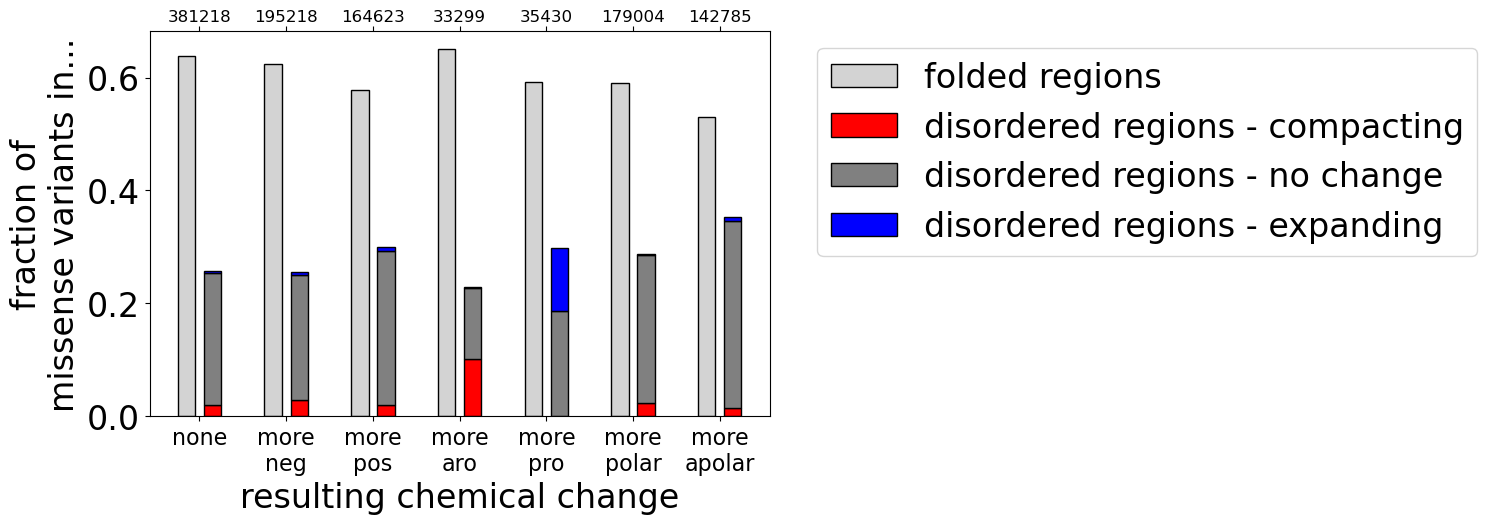

In [41]:
types = pd.DataFrame(index=data['changeType'].unique(),columns=['disordered','all','folded'])
changetypes=['none','pos>|>neg','neg>|>pos','>aro','>pro','>polar','>apolar']
fig,ax = plt.subplots(figsize=[8,5])
for i,changeType in enumerate(changetypes):
    sliced = data[data['changeType'].str.contains(changeType)]
    N_all = sliced.shape[0]
    N_folded = sliced[sliced['resDisordered']=='NO'].shape[0]
    N_disordered_compact = sliced[(sliced['resDisordered']=='YES')&(sliced['mut_vs_wt_Re_delta_30']<0)&(sliced['mut_vs_wt_Re_pval_30_adj']>1.3)].shape[0]
    N_disordered_expand = sliced[(sliced['resDisordered']=='YES')&(sliced['mut_vs_wt_Re_delta_30']>0)&(sliced['mut_vs_wt_Re_pval_30_adj']>1.3)].shape[0]
    N_disordered_nochange = sliced[(sliced['resDisordered']=='YES')&(sliced['mut_vs_wt_Re_pval_30_adj']<1.3)].shape[0]
#   print('all: %i, folded: %i, disordered: %i'%(N_all,N_folded,N_disordered_compact+N_disordered_nochange))
    #ax.bar(i-0.3,N_all,width=0.2)
    ax.text(i,0.7,str(N_all),ha='center',fontsize=12)
    ax.bar(i-0.15,N_folded/N_all,width=0.2,color='lightgrey',edgecolor='k',label='folded regions')
    ax.bar(i+0.15,N_disordered_compact/N_all,width=0.2,color='red',edgecolor='k',label='disordered regions - compacting')
    ax.bar(i+0.15,N_disordered_nochange/N_all,bottom=(N_disordered_compact)/N_all,width=0.2,color='grey',edgecolor='k',label='disordered regions - no change')
    ax.bar(i+0.15,N_disordered_expand/N_all,bottom=(N_disordered_nochange+N_disordered_compact)/N_all,width=0.2,color='blue',edgecolor='k',label='disordered regions - expanding')
    if i==0:
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        
ax.set_xticks(np.arange(i+1))
ax.set_xticklabels(['none','more\nneg','more\npos','more\naro','more\npro','more\npolar','more\napolar'],fontsize=16)
ax.set_xlabel('resulting chemical change')
_=ax.set_ylabel('fraction of\nmissense variants in...')
ax.tick_params(axis='x', top=True, bottom=True, labelbottom=True)
plt.savefig('missense_changes.svg')

## Output for GO onthology

In [44]:
Re_all_prots = data[(data['resDisordered']=='YES')]['upID'].unique()
Re_compact_prots = data[(data['resDisordered']=='YES')&(data['mut_vs_wt_Re_delta_30']<-1.5)&(data['mut_vs_wt_Re_pval_30_adj']>1.3)]['upID'].unique()
Re_expand_prots = data[(data['resDisordered']=='YES')&(data['mut_vs_wt_Re_delta_30']>1.5)&(data['mut_vs_wt_Re_pval_30_adj']>1.3)]['upID'].unique()

np.savetxt('compact.txt', Re_compact_prots, delimiter=',',fmt='%s') 
np.savetxt('expand.txt', Re_expand_prots, delimiter=',',fmt='%s') 
np.savetxt('all.txt', Re_all_prots, delimiter=',',fmt='%s')